In [1]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.6MB/s 


In [2]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm

In [3]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


In [ ]:
from Formulas import *


In [5]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [ ]:

#longitud del arreglo

from ipywidgets import *

def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales

  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

In [ ]:
def nwlakers(x,y,yerr,Sol,N,walkers,steps):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [ ]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


"""
Función de Maxima Probabilidad

"""




#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 

"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta


  #if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
  if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
  #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
  #if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
  #if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      return 0.0
  return -np.inf



# log probabilidad

"""posterior """
def log_probability(theta, x, y, yerr):
    lp = log_p1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 
# esta función de probabilidad previa toma diferentes intervalos para los difernetes parametros analisados en esta sección.
def log_p1 (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  a0=np.round(a0,3)

  if a0== 1570.0:
    #if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
    if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      return 0.0
  if i==-11221.095:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if a0==1743.971:
    if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      print('ok')
      return 0.0
  if a0==-14285.228:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if a0==-10111.419:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
        print('ok')
        return 0.0
  if  a0==2000.0:
    #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
    if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
      return 0.0
  return -np.inf   

#Modelo

Ajuste minimos cuadrados

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


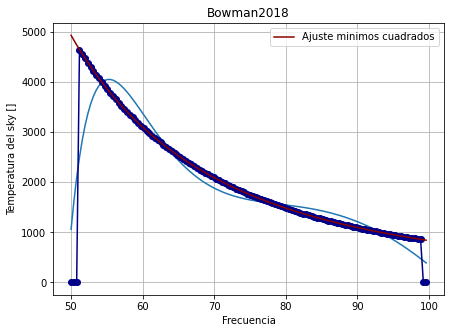

In [33]:

popt, pcov = curve_fit(T_sky, Dat[:,0], Dat[:,2])
x_1,y_1=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0]
popt1, pcov1 = curve_fit(T_sky, x_1, y_1)

#Arreglos datos
X=np.linspace(0,100,len(Dat))
Y=np.linspace(0,100,len(Dat))
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1),color='darkred',label='Ajuste minimos cuadrados')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()
plt.legend()

In [12]:
#popt_, pcov_ = curve_fit(T_f, x, y)

#popt_

los valores que en articulo encontraron para $τ = 7 $ ,
$0.37K< A< 0.67K$, $77.4MHz< ν0< 78.5MHz$ y $17.0MHz< w< 22.8MHz$.

#Modelos

#Selección de constantes

##Constantes le Bowman (EDges): 
Son las constantes usadas originalmente por el equipo de edges:


##Constantes Nature: 
En el articulo de Concerns about modelling of the EDGES data, se usan un conjunto de parametros diferentes a los de edges

##Constantes de Pyemcee

Son constante que se obtuvieron usando un modelo estadistico de pyemcee

##Cosntantes ajustando los an
Son constantes en las cuales se hallaron ajustado unicamente los an, tomando valores ya conocidos de A,v0,w,tau, y usando la rutina de curvefit de scipy

In [11]:
#Bow=1570.0/1000, 700.0/1000,-1100.0/1000,750.0/1000,-175.0/1000,0.567,78.3,20.75,800.0,0.05

Bow= 1570, 700,-1100,750,-175,0.530,78.3,20.75,8.0,0.05             # intersección con el eje y
Pyemcee= -11221.09499241, -14168.57143649, -10203.98895781,    144.62969775,12659.42909717,500.0/1000,78.3,19.0,7.0,0.05   #ajuste coeficientes de minimos cuadrados
Pyemcee2=  1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908, 0.524285560037914, 78.6235695471557, 21.162879332114997,7.6124372729808196,0.05
Intento= -14285.22801433, -17568.34439754, -12412.45765732,    167.33842652, 15700.28024181, 0.51948421412718, 78.51820480335225, 19.32741526388625, 7.001176416303,0.05
Natu_result= -10111.419 ,-5673.739 ,-1831.621 ,150.673 ,11711.500 ,0.553, 6.78 ,78.31 ,18.74,0.05
Natu= 2000, -720,1000,-720,175,1.12,78.3,19.5,2.8,0.05 
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

La siguiente tabla muetra los diferentes parametros usados, dependiendo de la fuente de donde fueron tomados, estan organizados de arriba hacia abajo de esta manera $a0,a1,a2,a3,a4,A,v0,w,tau $

In [12]:

Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(Cons),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 1570.0          -11221.095      1743.971        -14285.228     -10111.419      2000.0           |
| 700.0           -14168.571      147.55          -17568.344     -5673.739       -720.0           |
| -1100.0         -10203.989      -685.803        -12412.458     -1831.621       1000.0           |
| 750.0           144.63          36.537          167.338        150.673         -720.0           |
| -175.0          12659.429       -196.184        15700.28       11711.5         175.0            |
| 0.53            0.5             0.524           0.519          0.553           1.12             |
| 78.3            78.3            78.624          78.518         6.78            78.3             |


Como se puede ver en la tabla, el conjunto  de constantes que mas se asemeja a los parámetros usados por Bowman, son Pyemcee2, y los que mejor resultado presentan. Aun así, es interesante observar los demás arreglos de constantes 

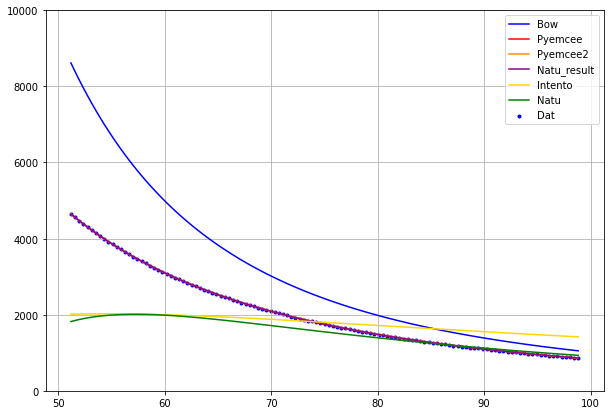

In [13]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
yerr=0.5
plt.figure(figsize=(10,7))
for i in range(len(Cons)):
  Const=Cons[i]
  plt.plot(x,T_sky(x,*Const[0:9]), color=Col[i] ,label=Cons_names[i])
#  plt.plot(x,T_sky(x,*Sol), color='darkred' )
plt.scatter(x,y,marker='.',color='blue',label='Dat')
plt.ylim(0,10000)
plt.legend()
plt.grid()

#Funciones de Maxima probalilidad


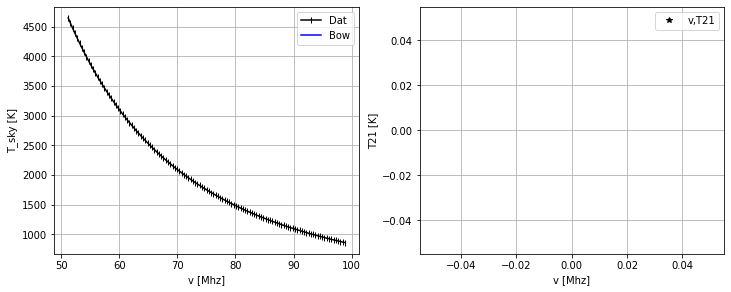

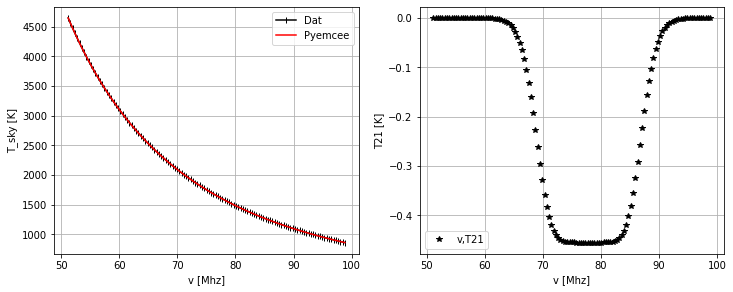

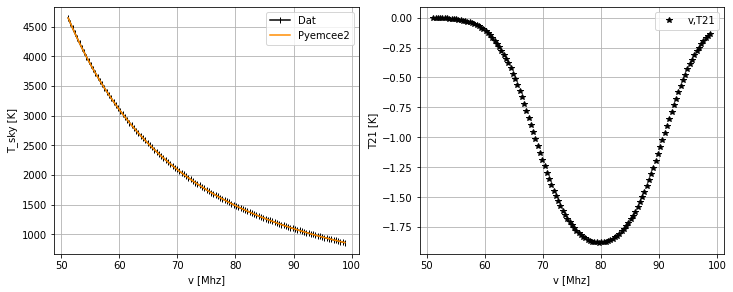

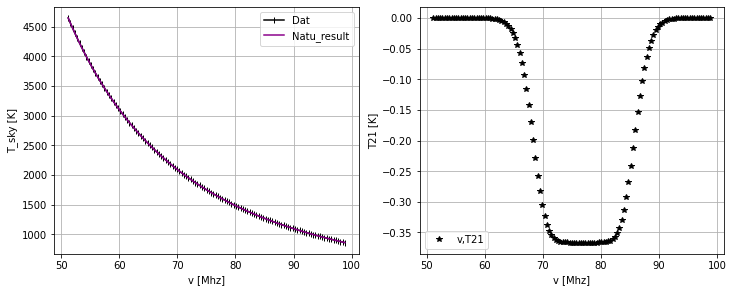

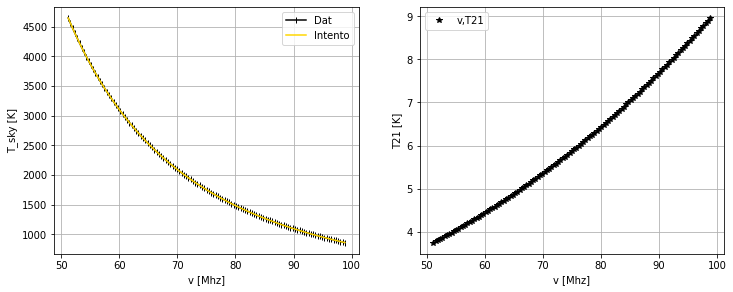

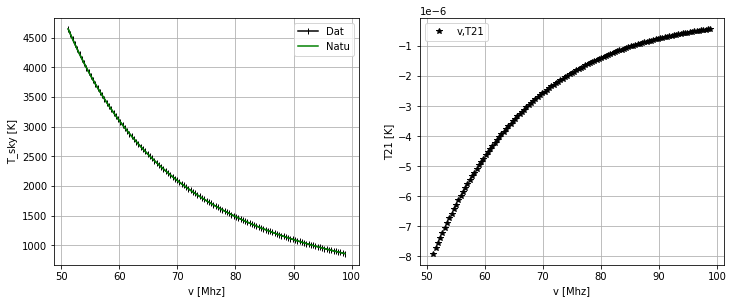

In [17]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables

for i in range(len(Cons)):
  sigma=0.5
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=T_modelo(x,y,yerr,Cons[i])
  plt.figure(figsize=(12,10))
  plt.subplot(2,2,1)
  plt.plot(x,y,marker='|',label='Dat',color='k')
  plt.plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i],label=Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T_sky [K]')
  plt.legend()
  plt.grid()
  plt.legend()
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21')
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()

#Cortando los arreglos

En vista que en articulo original de Bowman, solo usan el rango de frecuencias entre $60$ mhz y $94$ mhz, decidimos trabajar el modelo en ese rango para ver si los datos obtenidos se asemejaban mejor a los obtenidos en el texto

In [18]:
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]


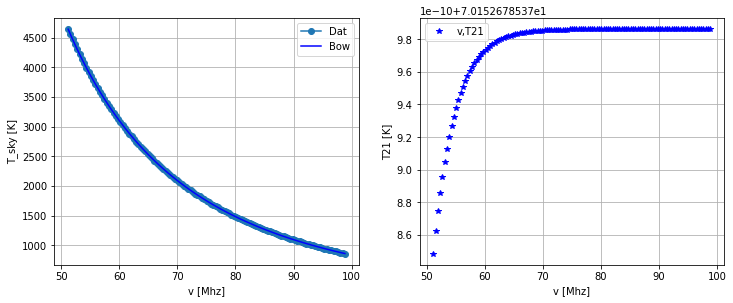

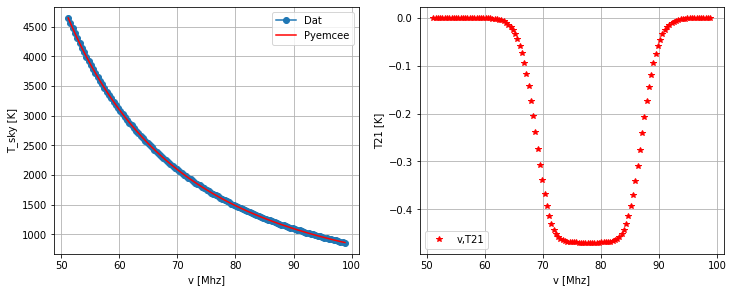

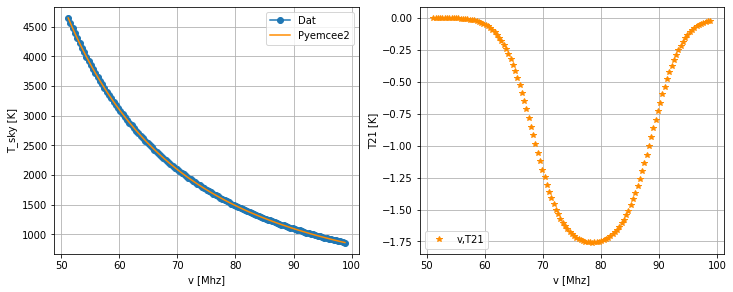

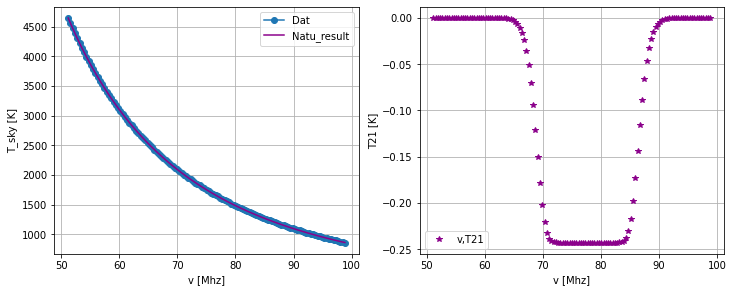

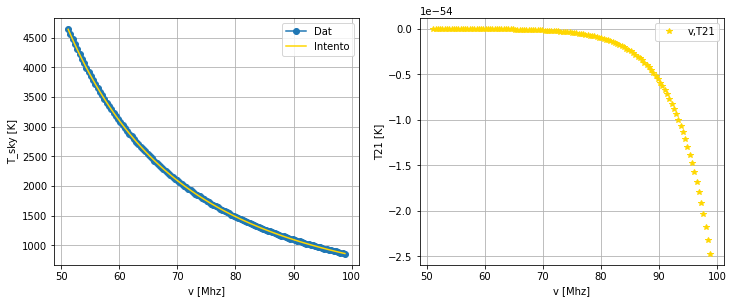

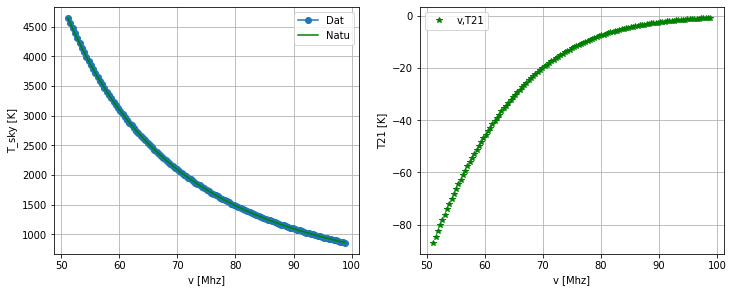

In [19]:
Constantes=np.zeros((6,9))

for i in range(len(Cons)):
  Constantes[i]=T_modelo(x_C,y_C,yerr,Cons[i])
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=Constantes[i]
  plt.figure(figsize=(12,10))
  plt.subplot(2,2,1)
  plt.plot(x,y,marker='o',label='Dat')
  plt.plot(x,T_sky(x,a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1),color=Col[i],label=Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T_sky [K]')
  plt.legend()
  plt.grid()
  plt.legend()
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()

## tabla con los parametros de maxima verosimilitud

In [20]:

Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(Constantes),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 2024.137        -11220.997      1744.277        -14284.832     -6519.871       1712.909         |
| 136.571         -14168.737      146.639         -17565.989     -9334.477       -1079.894        |
| -1385.425       -10203.881      -686.34         -12422.811     -5991.0         1663.989         |
| 37.255          144.685         37.024          167.562        44.522          -146.508         |
| -549.222        12659.131       -197.194        15699.847      8057.663        25.323           |
| -70.153         0.47            1.759           0.243          83.948          442.403          |
| 145.685         77.954          78.566          77.707         354.383         2.33             |


# Nwalkers 
 Hora vamos a observar los resultados de los nwlakers en los diferentes parámetros


100%|██████████| 10000/10000 [08:24<00:00, 19.83it/s]


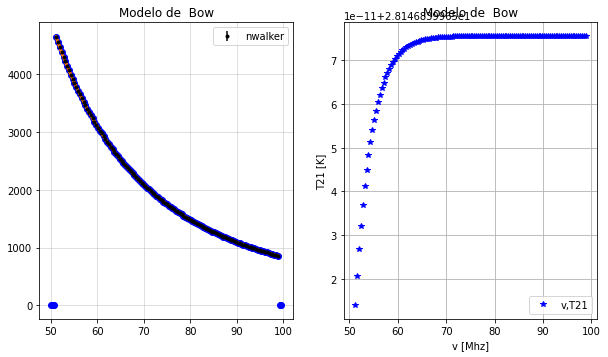

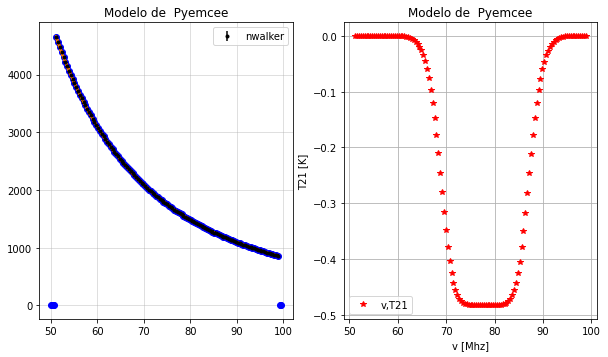

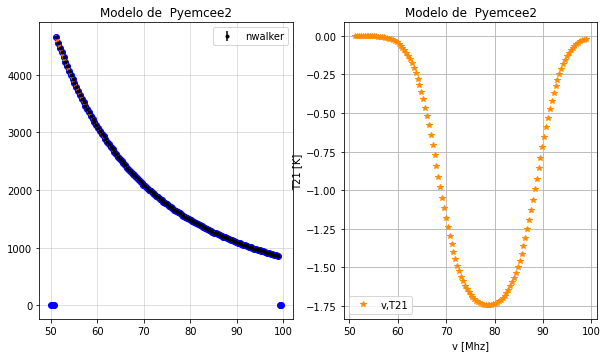

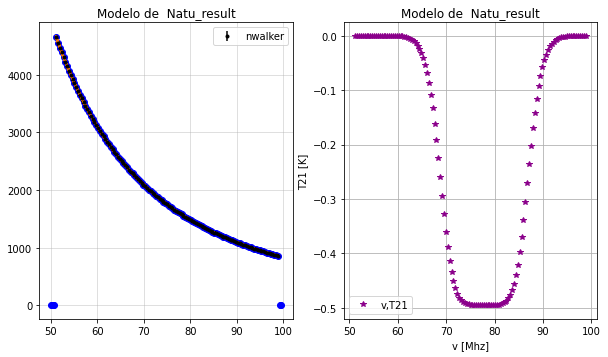

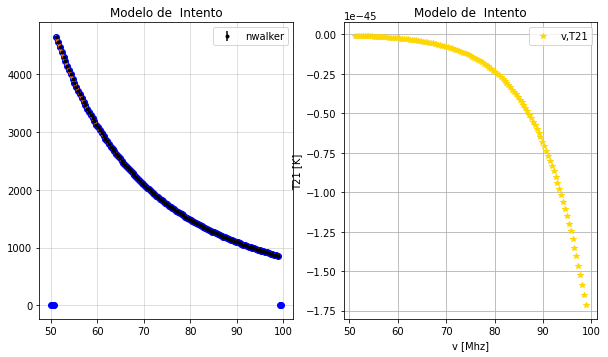

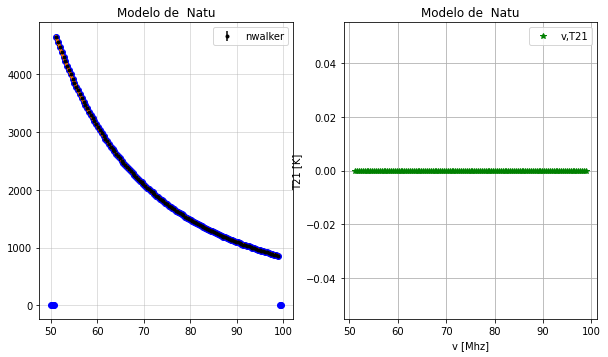

In [24]:
steps=10000 #pasos
Ncons= (len(Cons[0]))-1 # número de constantes (en este caso esta el menos 1 ya que los arreglos tienen el parametro sigma )

cc=np.zeros((len(Cons),len(Cons[0])-1))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr=np.zeros((len(Cons),22500,len(Cons[0])-1)) #Este arreglo vacio va a contener los n walkers  de los parametross
for i in range(len(Cons)):
  Sol=T_modelo(x_C,y_C,yerr,Cons[i])
  params=nwlakers(x_C,y_C,0.5,Sol[0:9],9,2500,steps)
  popt2=np.array(params.mean(axis=0))
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt2
  rr[i]=params
  cc[i]=(popt2 )
  plt.figure(figsize=(10,12))
  plt.subplot(2,2,1)
  plt.plot(Dat[:,0],Dat[:,2],'bo')
  for j in range(len(params)):
    ms=params[j]
    ms=ms[0:9]
    plt.plot(x,T_sky(x,*ms), "C1", alpha=0.1)
  plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
  #plt.xlim(min(x),max(x))
  plt.title('Modelo de  ' +Cons_names[i])
  #plt.ylim(min(y),max(y))
  plt.legend()
  plt.grid(alpha=0.5)
  plt.subplot(2,2,2)
  plt.plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  plt.title('Modelo de  ' +Cons_names[i])
  plt.xlabel('v [Mhz]')
  plt.ylabel('T21 [K]')
  plt.legend()
  plt.grid()
  plt.legend()

In [60]:
params

array([], shape=(0, 9), dtype=float64)

In [25]:
Tabla = """\
+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<15} {:<15} {:<15} {:<15}{:<15} {:<15}  |".format(*fila)
 for fila in np.round(np.transpose(cc),3))))
print (Tabla)

+-------------------------------------------------------------------------------------------------+
|Bow               Pyemcee        Pyemcee2         Intento        Natu_result     Natu            |
|-------------------------------------------------------------------------------------------------|
| 1791.732        -11221.027      1744.285        -14277.818     -6496.256       1754.647         |
| -288.74         -14168.719      146.527         -17439.53      -9308.749       -444.217         |
| -248.226        -10204.046      -686.081        -12672.511     -5972.859       606.261          |
| -23.902         144.689         37.027          187.926        44.295          -66.13           |
| -213.736        12659.188       -197.161        15672.759      8034.325        -106.184         |
| -28.147         0.483           1.745           0.496          90.527          234.988          |
| 151.532         77.949          78.569          77.806         348.256         -53.767          |


La tabla anterior tiene los valores medios de los walker de los diferentes parametros

##Grafico de esquina:

Bow


<Figure size 432x288 with 0 Axes>

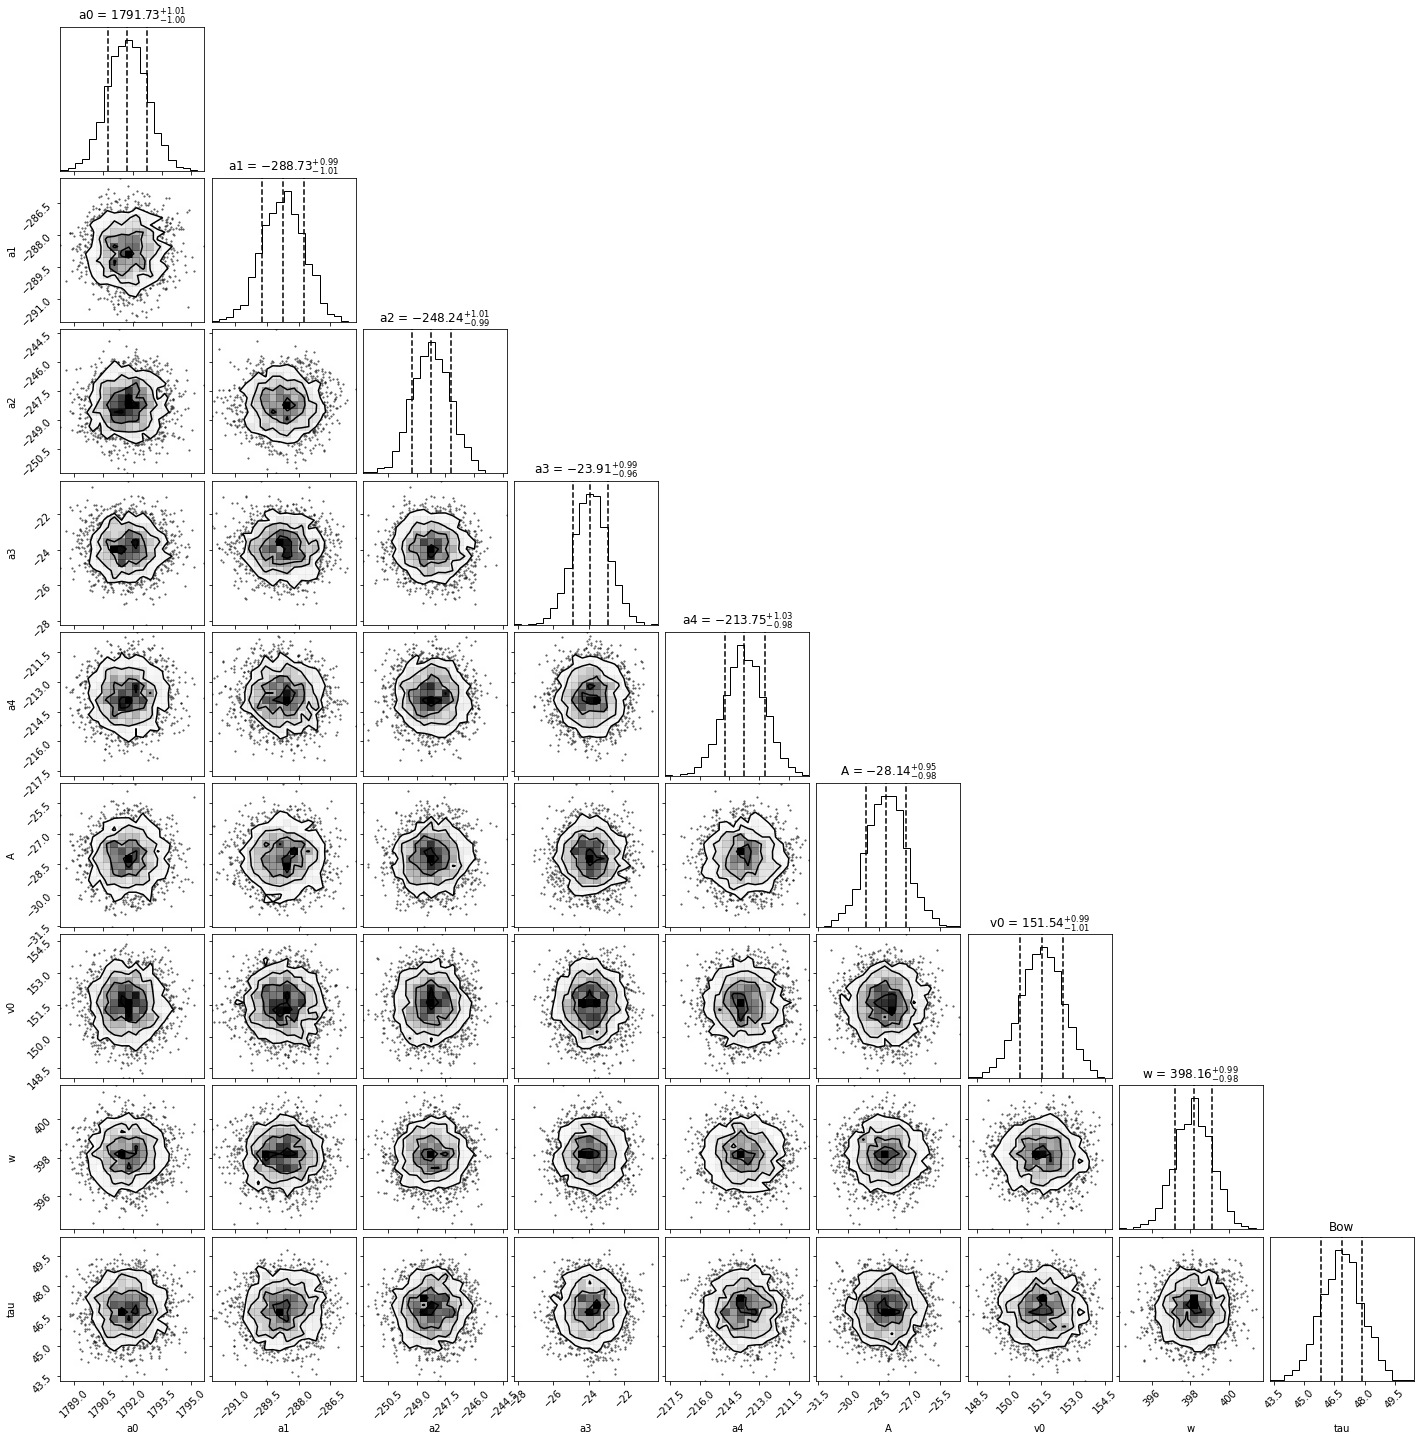

Pyemcee


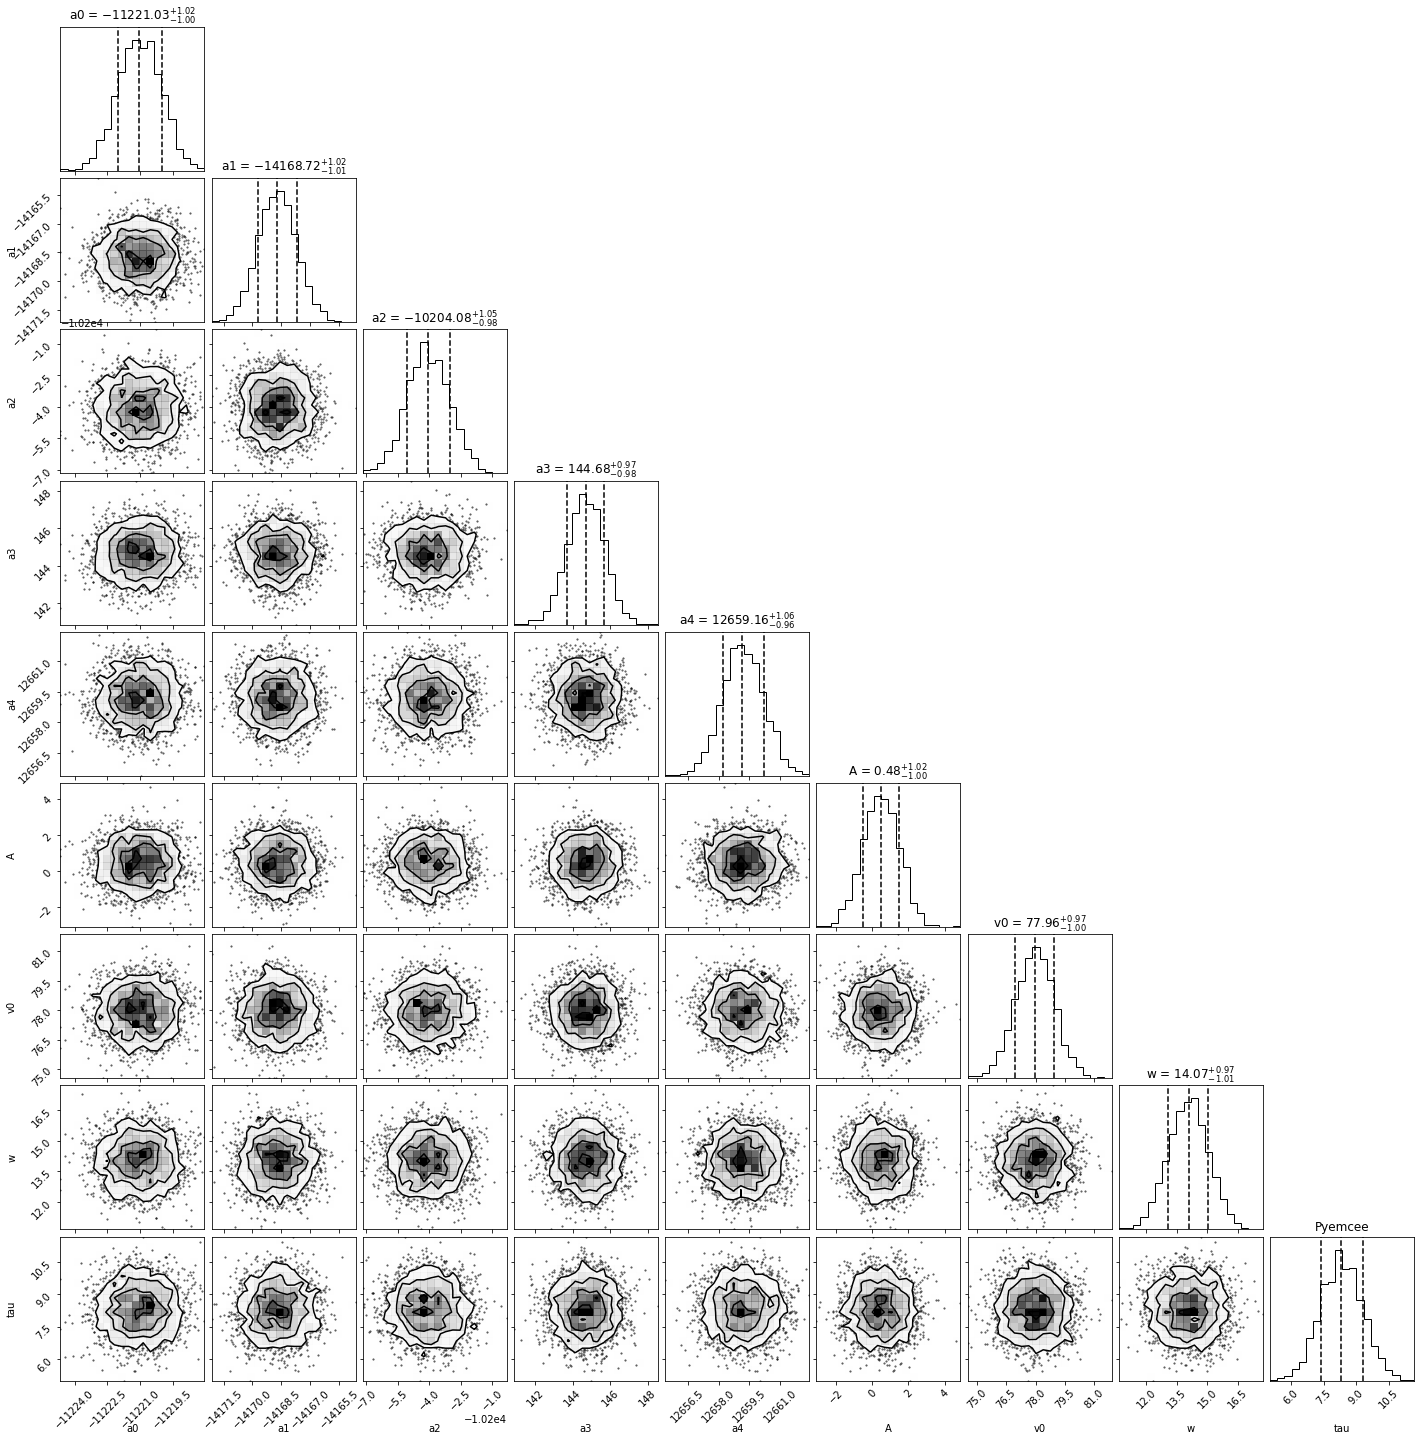

Pyemcee2


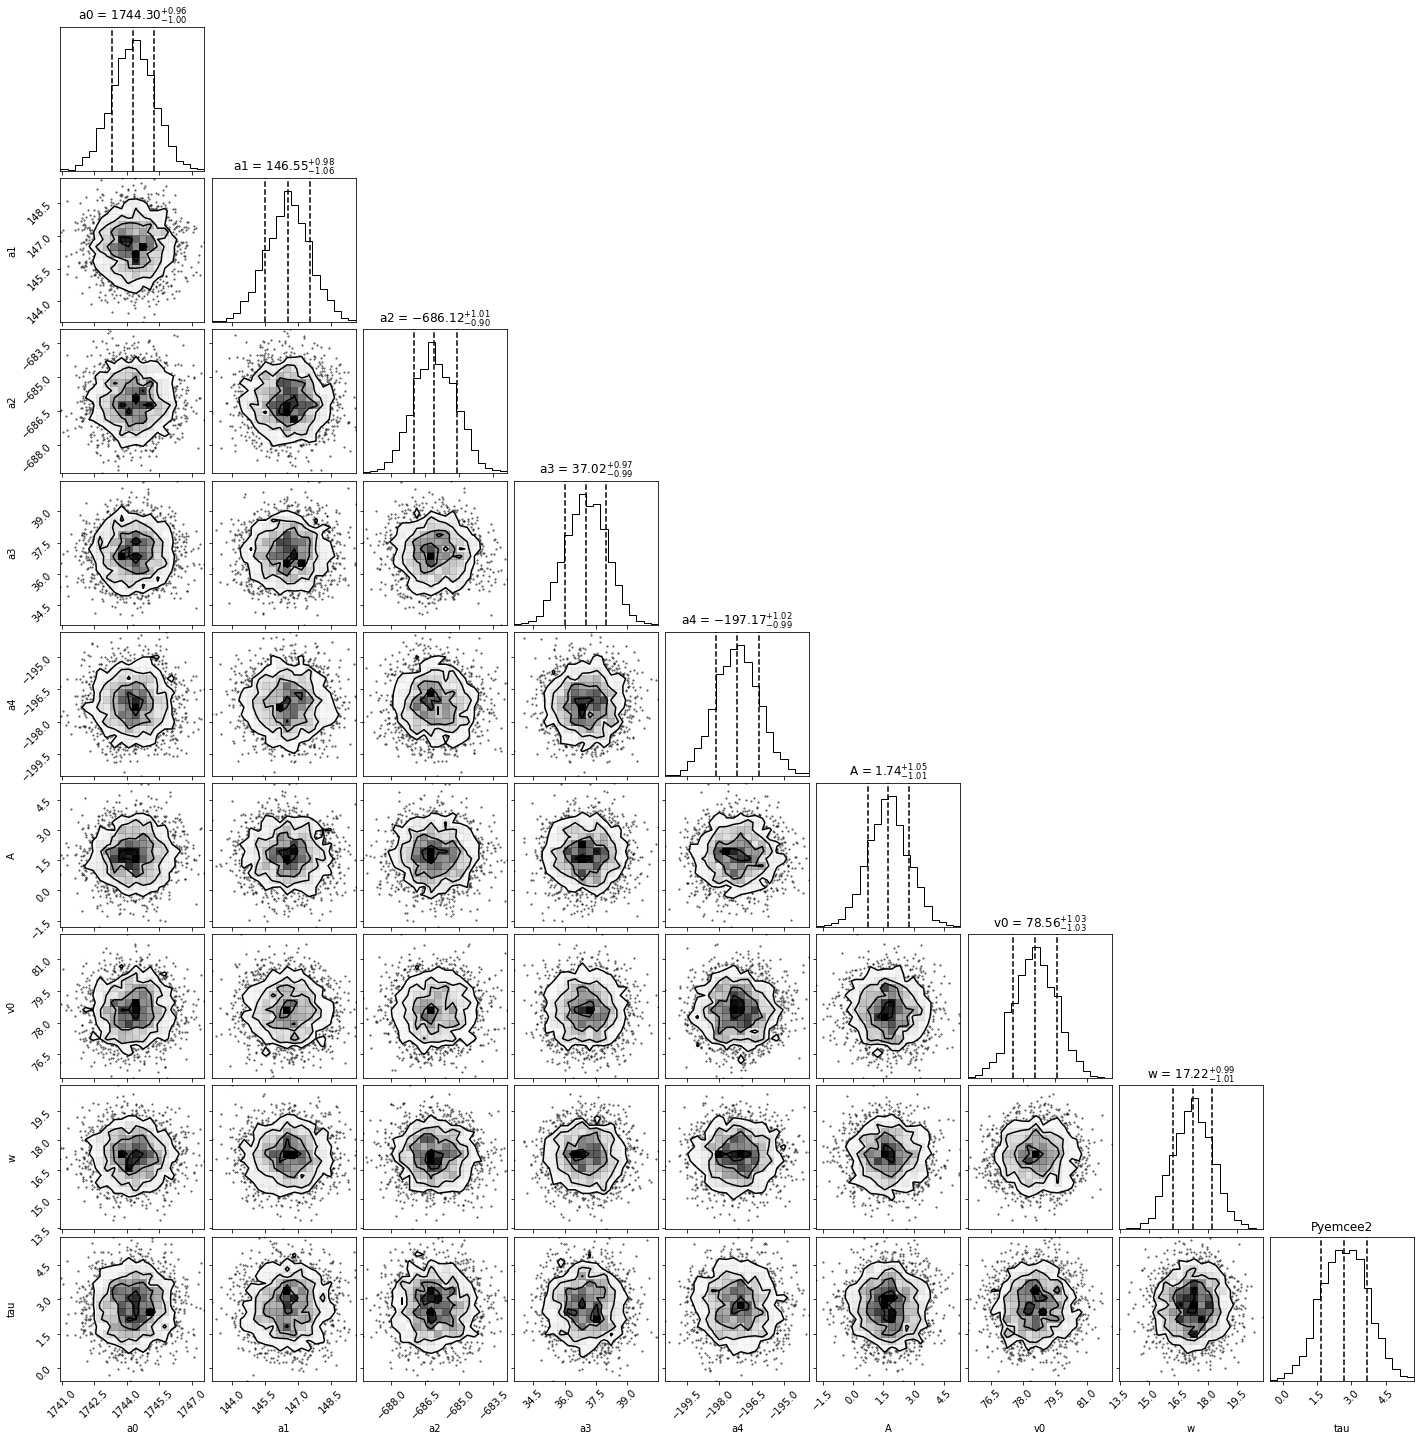

Natu_result


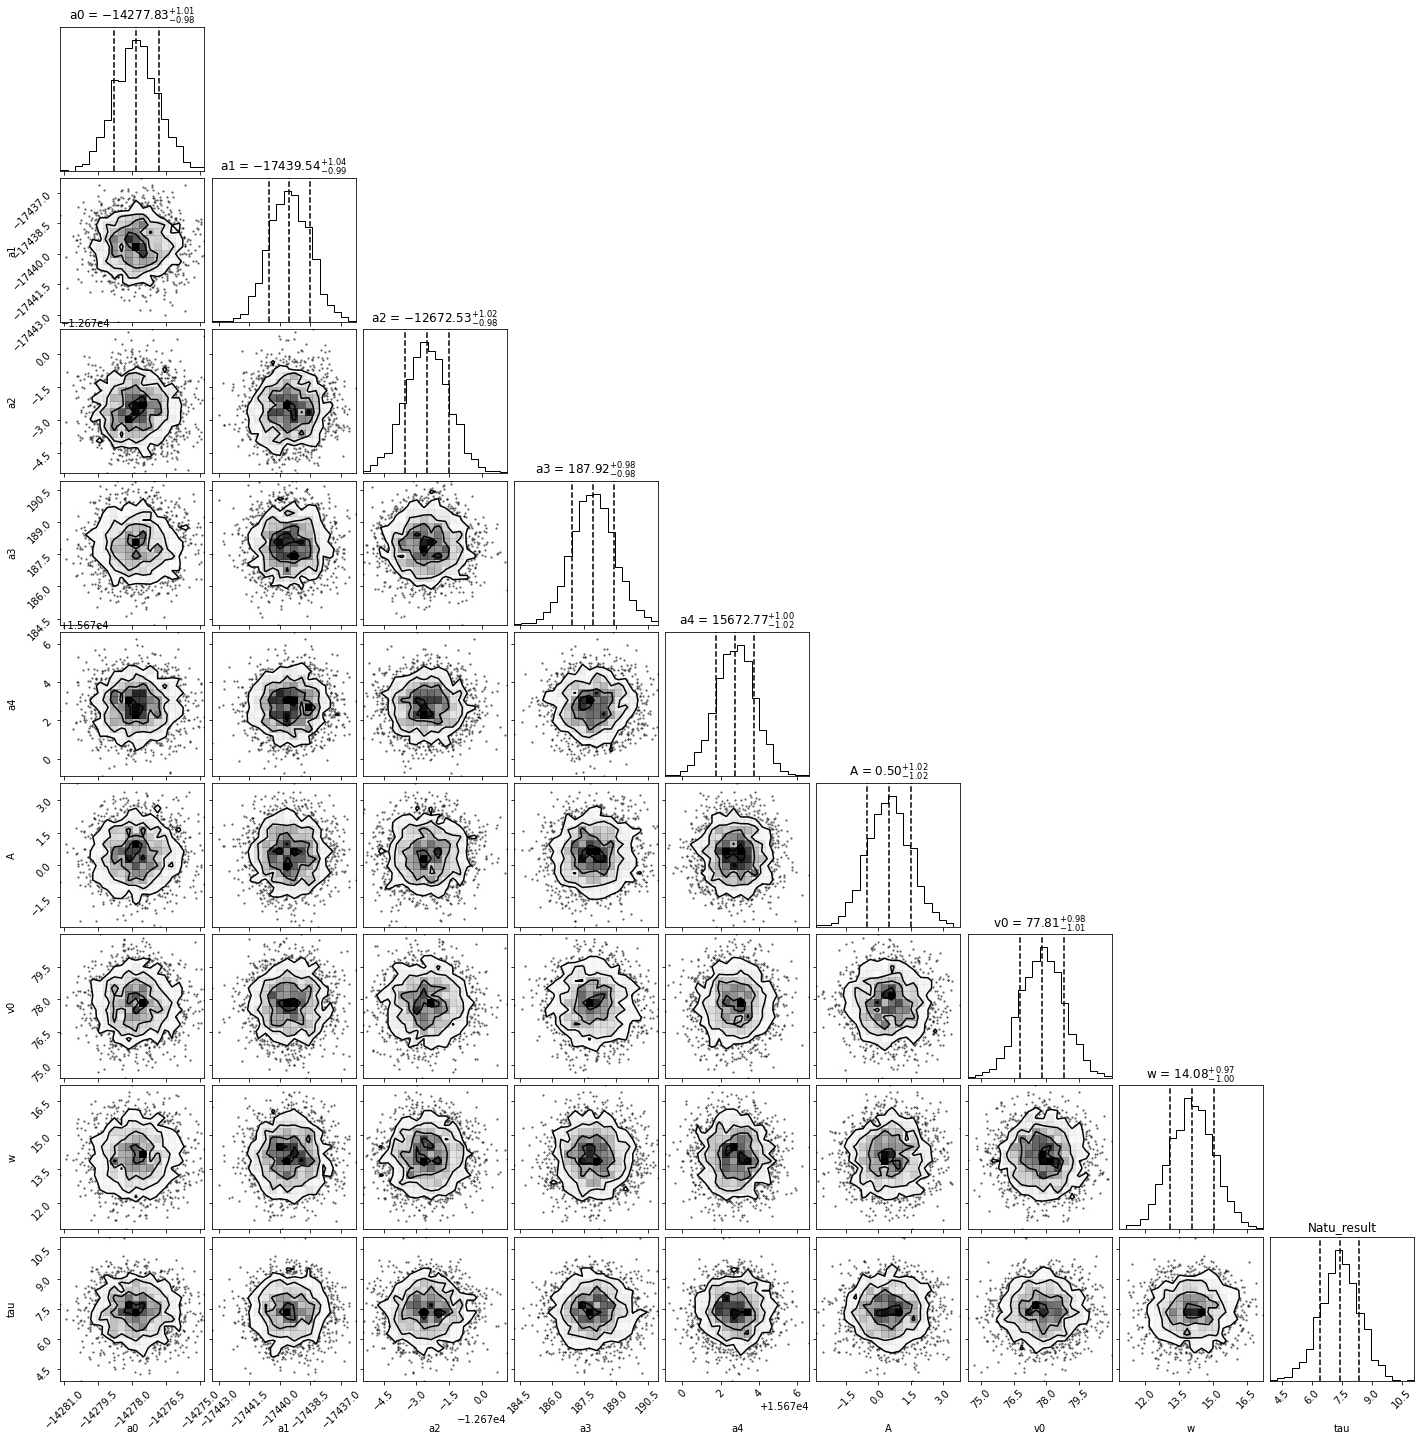

Intento


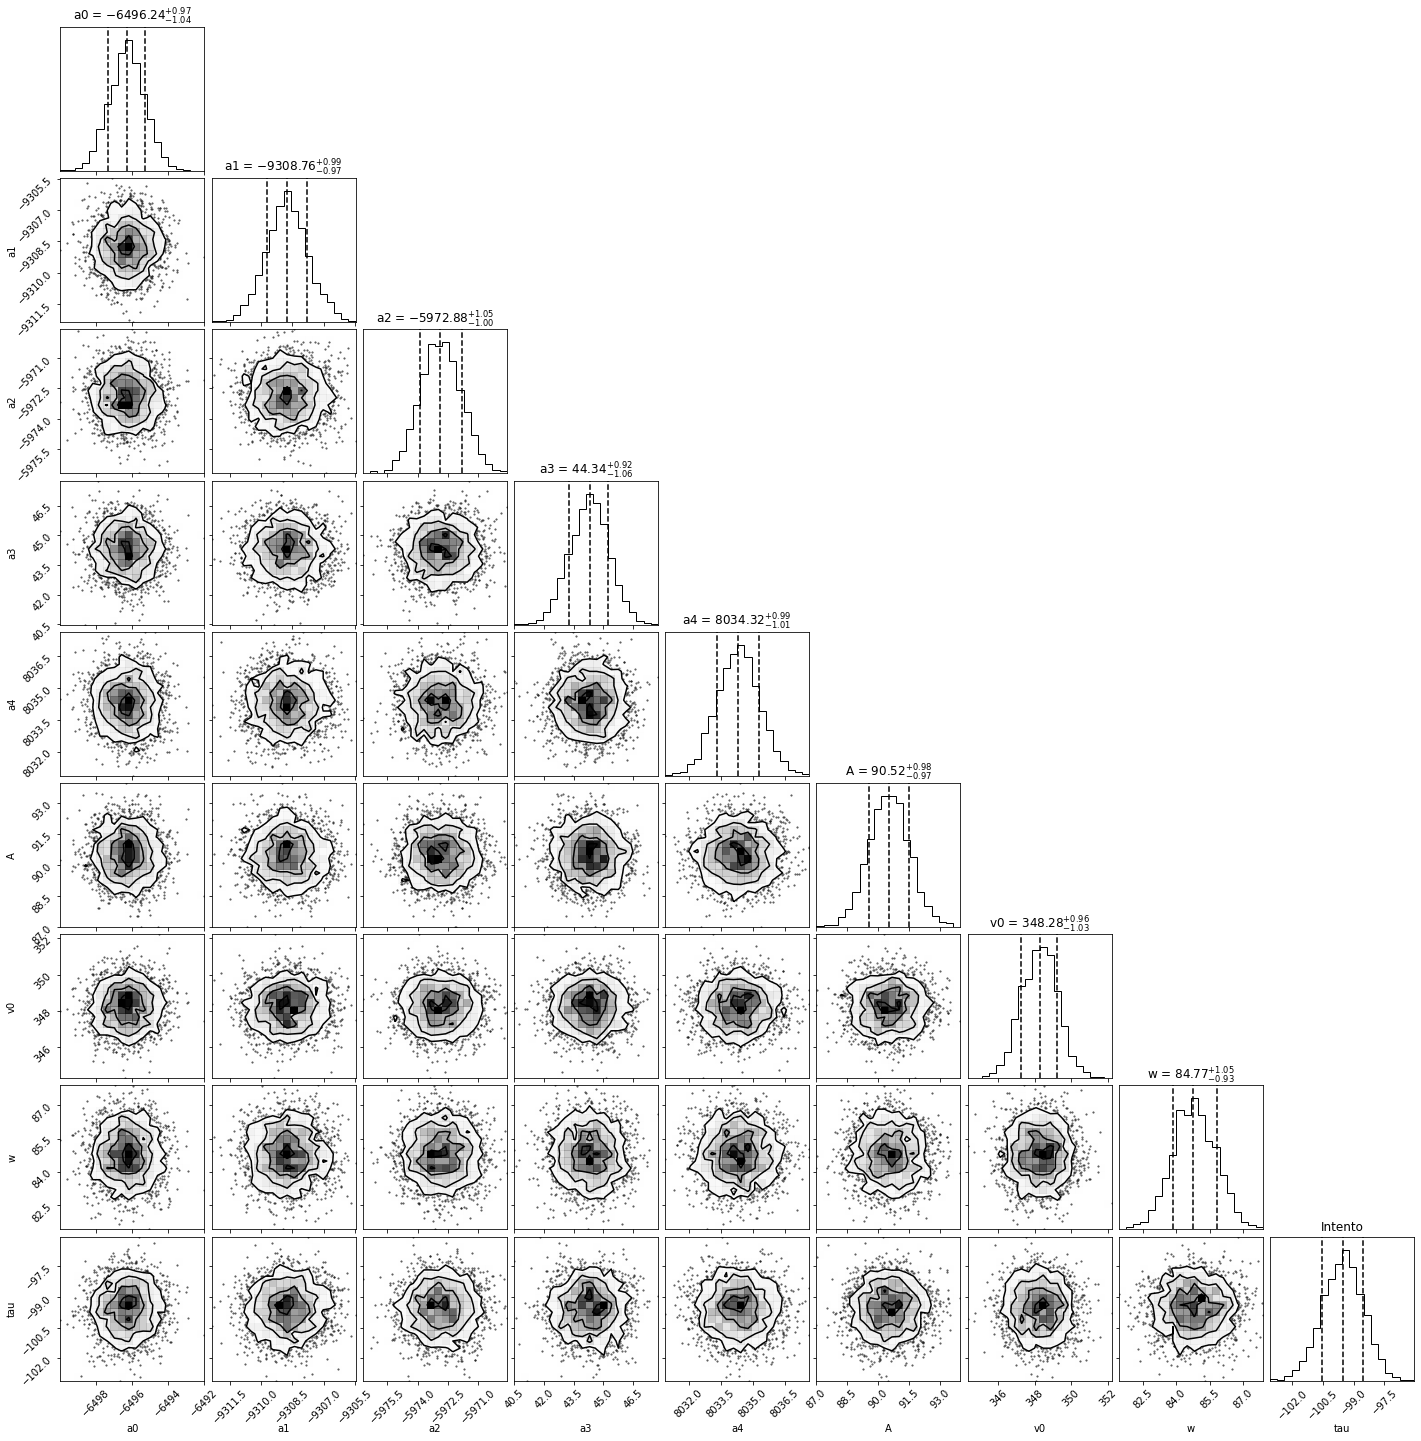

Natu


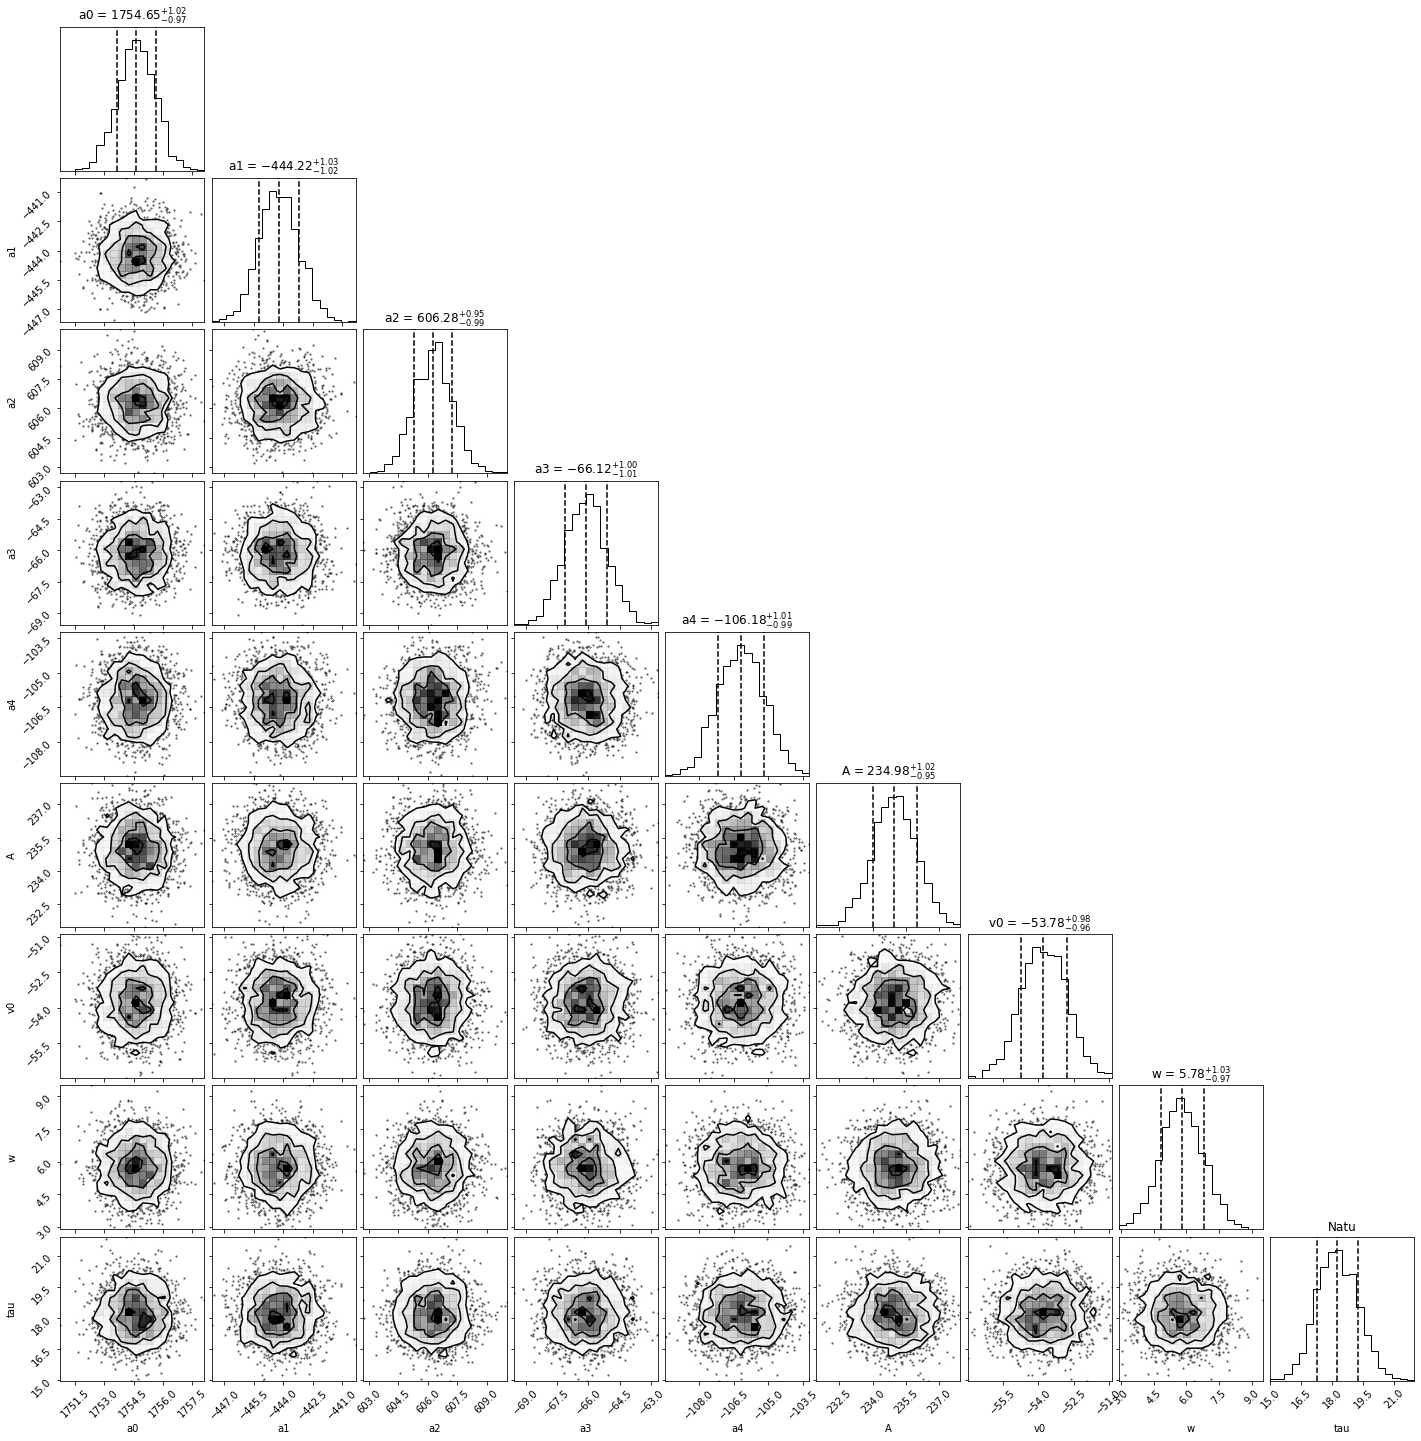

In [37]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
plt.figure()
for i in range(len(Cons)):
  
  print(Cons_names[i])
  corner.corner(rr[i],labels=names,quantiles=[0.16, 0.5, 0.84],show_titles=True)
  plt.title(Cons_names[i]) 
  plt.show()

#Tiempo de Autocorrelación


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


'     \n    autocorr=np.asarray(autocorr)\nprint("Autocorrelation time for "+str(names))\nautocorr_=autocorr\nplt.figure()\nplt.hist(autocorr_,alpha=0.5)\nprint("Mean: ",autocorr_.mean(),"Stdev: ",autocorr_.std())\nplt.title(names[j])\nplt.xlabel("Autocorrelation time (steps)")\nplt.ylabel("Frequency")\nplt.legend(\n          names,\n          scatterpoints=1,\n          loc=\'upper right\',\n          ncol=10,\n          fontsize=11)\n'

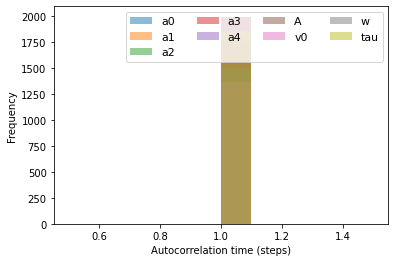

In [32]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
for j in range(9): # Range NConstans
    autocorr=[]
    for i in range(2500): # Range NWalker 
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           names,
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

"""     
    autocorr=np.asarray(autocorr)
print("Autocorrelation time for "+str(names))
autocorr_=autocorr
plt.figure()
plt.hist(autocorr_,alpha=0.5)
print("Mean: ",autocorr_.mean(),"Stdev: ",autocorr_.std())
plt.title(names[j])
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
          names,
          scatterpoints=1,
          loc='upper right',
          ncol=10,
          fontsize=11)
"""

#Residuales

In [ ]:
a0,a1,a2,a3,a4,A,v0,w,tau,sigma=popt2
v=x
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(v, T_21(v,A,v0,w,tau),'k*')
plt.title(' Frecuncia vs Temperatura $21_cm$ ($T_{21}$) ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4),'k*')
plt.title(' Frecuncia vs Tempera del foreground $T_f$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)+ T_21(v,A,v0,w,tau),'k*')
plt.title(r' Frecuncia vs $T_{Sky}$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)- T_21(v,A,v0,w,tau),'k*',label='v,Tf-T21')
plt.title(' Frecuncia vs $T_f$ - $T_21$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()

In [ ]:
steps=100 #pasos
Ncons= (len(Cons[0]))-1 # número de constantes (en este caso esta el menos 1 ya que los arreglos tienen el parametro sigma )

cc=np.zeros((len(Cons),len(Cons[0])-1))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr=np.zeros((len(Cons),steps,len(Cons[0])-1)) #Este arreglo vacio va a contener los n walkers  de los parametross
autocorr_time=np.zeros((Ncons,1000))
for i in range(len(Cons)):
  Sol=T_modelo(x_C,y_C,yerr,Cons[i])
  sampler=nwlakers(x_C,y_C,0.5,Sol[0:9],Ncons,2500,steps)
  autocorr=Time_autocorr(sampler,i,Ncons,2500)
  popt2=np.array(params.mean(axis=0))
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt2
 # rr[i]=params
 # cc[i]=(popt2 )


In [ ]:
r=np.zeros(np.shape(params))
rr=np.zeros((6,10000,9))
np.shape(rr[2])
len(rr[0])
rr[0]=params
len(Cons[0])
cc[0 ]

In [15]:


#longitud del arreglo

from ipywidgets import *

def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales

  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

In [16]:
def nwlakers(x,y,yerr,Sol,N,walkers,steps):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params
  """
  plt.figure(figsize=(8,5))
  plt.plot(Dat[:,0],Dat[:,2],'bo')
  for j in range(len(params)):
    ms=params[j]
    ms=ms[0:9]
    plt.plot( ,T_sky(x,*ms), "C1", alpha=0.1)
  plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
  #plt.xlim(min(x),max(x))
  plt.title('Modelo')
  #plt.ylim(min(y),max(y))
  plt.legend()
  plt.grid(alpha=0.5)
  """

In [19]:


def Time_autocorr(sampler,k,Ncons,steps):
  for j in range(Ncons):
      autocorr=[]
      for i in range(1000):
          autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
      autocorr=np.asarray(autocorr)
  autocorr_time[k]=autocorr[:,0]
  return autocorr_time

In [7]:
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4):
  A,v0,w,tau=0.530,78.3,20.75,7.0
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf
def TTT(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=78.0 # frecuancia central (EDGES) 
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2 -A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

In [8]:
#vc=np.median(v) #Frecuancia central
vc=75.0 # frecuancia central (EDGES) 
def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=78.0 # [Mhz]
  B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau)))
def log_likelihood(theta, x, y, yerr):
    v=x
    a0,a1,a2,a3,a4,A,v0,w,tau,sigma = theta
    B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
    model = a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau)))
    sigma2 = yerr ** 2 #+ model ** 2 #* np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [9]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


"""
Función de Maxima Probabilidad

"""




#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 

"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta


  #if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
  if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
  #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
  #if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
  #if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      return 0.0
  return -np.inf



# log probabilidad

"""posterior """
def log_probability(theta, x, y, yerr):
    lp = log_p1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 

def log_p1 (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  a0=np.round(a0,3)

  if a0== 1570.0:
    #if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
    if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      return 0.0
  if i==-11221.095:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if a0==1743.971:
    if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      print('ok')
      return 0.0
  if a0==-14285.228:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if a0==-10111.419:
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
        print('ok')
        return 0.0
  if  a0==2000.0:
    #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
    if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
      return 0.0
  return -np.inf    